# Multiple materials for sample model  

In [48]:
%pylab inline
import condor
import spimage
import seaborn as sns
sns.set_style("white")

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [24]:
# CORE
diameter_core = 50E-9
atomic_composition_core = {"Xe": 1.}
massdensity_core = 3640.

# SHELL
thickness_shell = 30E-9
atomic_composition_shell = {"H": 2., "O": 1.}
massdensity_shell = 1000.

1.88449848024e-09
1.77142857143e-09


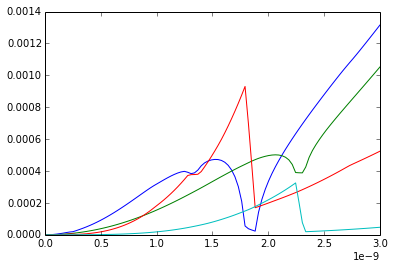

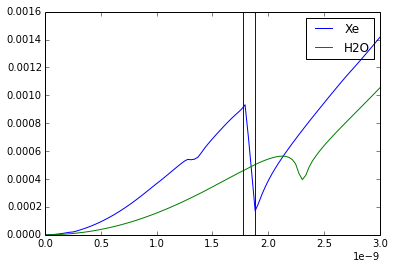

In [25]:
MXe = condor.utils.material.AtomDensityMaterial(material_type="custom", atomic_composition=atomic_composition_core, massdensity=massdensity_core)
MH2O = condor.utils.material.AtomDensityMaterial(material_type="custom", atomic_composition=atomic_composition_shell, massdensity=massdensity_shell)

wavelengths = linspace(0.01E-9, 3.0E-9, 100)
dnXe = array([MXe.get_dn(photon_wavelength=wl) for wl in wavelengths])
dnH2O = array([MH2O.get_dn(photon_wavelength=wl) for wl in wavelengths])

plot(wavelengths, dnXe.real)
plot(wavelengths, dnH2O.real)
plot(wavelengths, dnXe.imag)
plot(wavelengths, dnH2O.imag)

figure()
plot(wavelengths, abs(dnXe))
plot(wavelengths, abs(dnH2O))
legend(["Xe", "H2O"])
EPhArray=[658.,700.]
for EPh in EPhArray:
    WL=1240./EPh*1E-9
    print WL
    axvline(WL)


In [57]:
D = 0.15
def simulate(wavelength):
    S = condor.Source(wavelength=wavelength, pulse_energy=1E-3, focus_diameter=2E-6)
    D = condor.Detector(pixel_size=75E-6, nx=1024, ny=1024, distance=D)
    # Build 3D map for particle model
    dx = 0.5*D.get_resolution_element_x(S.photon.get_wavelength())
    N = int(round((1.2*diameter_core+2*thickness_shell)/dx))
    assert (dx*N) > (1.1*diameter_core+2*thickness_shell)
    map3d = zeros(shape=(2,N,N,N))
    X,Y,Z = mgrid[:N,:N,:N]
    R = sqrt((X-(N-1)/2.)**2+(Y-(N-1)/2.)**2+(Z-(N-1)/2.)**2)*dx
    (map3d[0])[R <= diameter_core/2.] = 1.
    (map3d[1])[(R > diameter_core/2.)*(R <= (diameter_core+thickness_shell*2)/2.)] = 1.
    # Check created maps
    #imshow(map3d[0,:,:,:].sum(0))
    #figure()
    #imshow(map3d[1,:,:,:].sum(0))

    # Initialise particle class instance
    P = condor.ParticleMap(geometry='custom',
                           material_type=['custom','custom'], 
                           dx=dx, map3d=map3d,
                           atomic_composition=[atomic_composition_core, atomic_composition_shell],
                           massdensity=[massdensity_core, massdensity_shell])
    
    # Initialise experiment class instance
    E = condor.Experiment(source=S, particles={"particle_map": P}, detector=D)
    # Calculate diffraction pattern
    res = E.propagate()
    # Images for plotting
    img_intensities = res["entry_1"]["data_1"]["data"]
    img_intensities_poiosson = poisson(img_intensities)
    img_fourier = res["entry_1"]["data_1"]["data_fourier"]
    rs = abs(fftshift(fft2(fftshift(img_fourier))))
    return img_intensities, img_fourier, rs

In [52]:
imgs_int = []
imgs_rs = []
Es_eV = [635.,645.]
for E_eV in Es_eV:
    wl = condor.source.Photon(energy_eV=E_eV).get_wavelength()
    img_intensities, img_fourier, rs = simulate(wl)
    imgs_int.append(img_intensities)
    imgs_rs.append(rs)

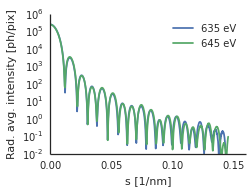

In [80]:
figure(figsize=(3.5,2.5))
for E_eV, I in zip(Es_eV, imgs_int):
    wl = condor.source.Photon(energy_eV=E_eV).get_wavelength()
    rI = spimage.radialMeanImage(I)
    r = arange(len(rI))*75E-6
    p = array([[ri, 0., D] for ri in r])
    q = abs(array([condor.utils.scattering_vector.q_from_p(p_i, wl) for p_i in p]).sum(1))
    s_nm = q/(2*pi)*1E-9
    semilogy(s_nm, rI)
leg = ["%i eV" % E_eV for E_eV in Es_eV]
legend(leg)
sns.despine()
ylabel("Rad. avg. intensity [ph/pix]")
xlabel("s [1/nm]")
xticks([0., 0.05, 0.1, 0.15])
ylim(1E-2, None)
savefig("Is.pdf")